
## Практическое задание к уроку "Сегментация"¶
1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Можете взять один из этих наборов данных:

https://www.kaggle.com/carlolepelaars/camvid

https://www.kaggle.com/dansbecker/cityscapes-image-pairs

https://www.kaggle.com/tapakah68/segmentation-full-body-mads-dataset

https://www.kaggle.com/longnguyen2306/bacteria-detection-with-darkfield-microscopy

https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

Опишите в комментарии - какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from keras.preprocessing import image
from PIL import Image

In [3]:
class_dict = pd.read_csv('../Lesson_6.Segmentation/CamVid/class_dict.csv')

# Пути к директориям с данными
path_train = '../Lesson_6.Segmentation/CamVid/train/'
path_train_labels = '../Lesson_6.Segmentation/CamVid/train_labels/'
path_test = '../Lesson_6.Segmentation/CamVid/test/'
path_test_labels = '../Lesson_6.Segmentation/CamVid/test_labels/'
path_val = '../Lesson_6.Segmentation/CamVid/val/'
path_val_labels = '../Lesson_6.Segmentation/CamVid/val_labels/'

train_images_paths = list(Path(path_train).iterdir())

In [4]:
# Загрузите одно изображение с помощью PIL (Pillow)
single_image = Image.open(train_images_paths[0])

# Рассчитать новый размер изображения
image_size = (int(single_image.size[0] / 2), single_image.size[1])
image_size

(480, 720)

### Загружаем картинки 

Размеры делятся на 2 несколько раз, можно было оставить исходные. Но при преобразовании датасета заканчивается объем ОЗУ на коллабе, поэтому сожму картинки.

In [5]:
from keras.preprocessing import image

train_imgs_paths = list(sorted(Path(path_train).iterdir()))
train_masks_paths = list(sorted(Path(path_train_labels).iterdir()))
test_imgs_paths = list(sorted(Path(path_test).iterdir()))
test_masks_paths = list(sorted(Path(path_test_labels).iterdir()))
val_imgs_paths = list(sorted(Path(path_val).iterdir()))
val_masks_paths = list(sorted(Path(path_val_labels).iterdir()))

In [6]:
image_size = (128, 192)

In [7]:
train_images = []
train_masks = []

for i_img, i_mask in zip(train_imgs_paths, train_masks_paths):
    train_images.append(Image.open(i_img).resize(image_size))
    train_masks.append(Image.open(i_mask).resize(image_size))

In [8]:
test_images = []
test_masks = []

for i_img, i_mask in zip(test_imgs_paths, test_masks_paths):
    test_images.append(Image.open(i_img).resize(image_size))
    test_masks.append(Image.open(i_mask).resize(image_size))

In [9]:
val_images = []
val_masks = []

for i_img, i_mask in zip(val_imgs_paths, val_masks_paths):
    val_images.append(Image.open(i_img).resize(image_size))
    val_masks.append(Image.open(i_mask).resize(image_size))

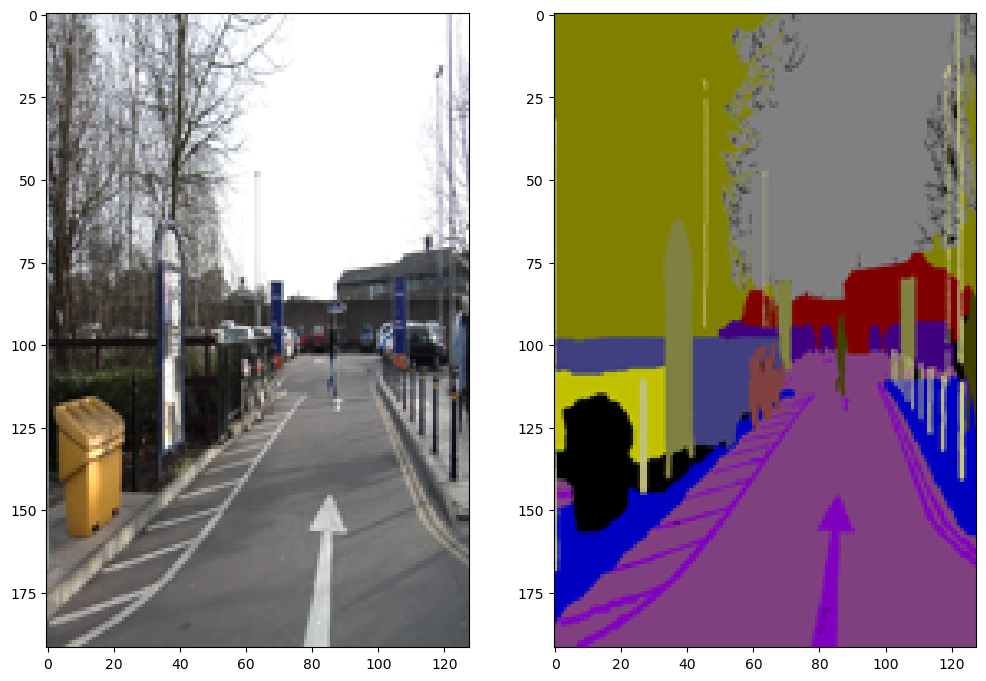

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(train_images[80].convert('RGBA'))
ax[1].imshow(train_masks[80].convert('RGBA'))

In [11]:
X_train = []

for img in train_images:
    x = np.array(img)
    X_train.append(x)

X_train = np.array(X_train)
print(X_train.shape)

(369, 192, 128, 3)


In [12]:
X_test = []

for img in test_images:
    x = np.array(img)
    X_test.append(x)

X_test = np.array(X_test)
print(X_test.shape)

(232, 192, 128, 3)


In [13]:
X_val = []

for img in val_images:
    x = np.array(img)
    X_val.append(x)

X_val = np.array(X_val)
print(X_val.shape)

(100, 192, 128, 3)


### Посмотрим на разметку

In [14]:
class_dict

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0
5,Car,64,0,128
6,CartLuggagePram,64,0,192
7,Child,192,128,64
8,Column_Pole,192,192,128
9,Fence,64,64,128


In [15]:
arr_col = []

for r, g, b in zip(class_dict['r'], class_dict['g'], class_dict['b']):
  arr_col.append([r, g, b]) 

In [16]:
import cv2

def Color2index(y, arr_col=arr_col):

    y_ind = np.zeros((y.shape[0], y.shape[1]))
    y_cat = np.zeros((y.shape[0], y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        ind_i = np.where(
            (y[..., 0] == i_color[0]) 
            & (y[..., 1] == i_color[1])
            & (y[..., 2] == i_color[2])
        )
        y_ind[ind_i[0], ind_i[1]] = i
        y_cat[ind_i[0], ind_i[1], i-1] = 1 
        i += 1
    
    return y_cat, y_ind #, i-1

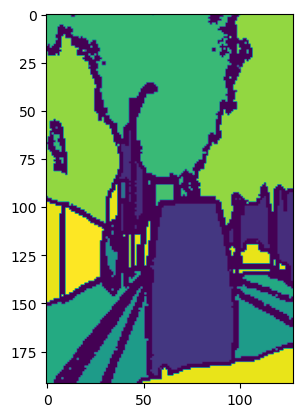

In [19]:
def color_to_index(y, class_dict):
    # Function to convert color mask to class index mask
    img_size = y.shape[:2]
    y_index = np.zeros(img_size)
    for i, color in enumerate(class_dict[['r', 'g', 'b']].values):
        ind_i = np.where((y[..., :3] == color).all(axis=-1))
        y_index[ind_i[0], ind_i[1]] = i
    return y_index

# Assuming you have the 'class_dict' DataFrame already defined

# Load the image and mask
img_path = train_imgs_paths[3]
mask_path = train_masks_paths[3]
img = Image.open(img_path).resize(image_size)
mask = Image.open(mask_path).resize(image_size)

# Convert the mask to class index mask
mask_index = color_to_index(np.array(mask), class_dict)

# Show the class index mask
plt.imshow(mask_index)
plt.show()

ind_yi = mask_index

In [20]:
ind_yi

array([[21., 21., 21., ..., 26., 26., 26.],
       [21., 21., 21., ..., 26., 26., 26.],
       [21., 21., 21., ..., 26., 26., 26.],
       ...,
       [19., 19., 19., ..., 30., 30., 30.],
       [19., 19., 19., ..., 30., 30., 30.],
       [19., 19., 19., ..., 30., 30., 30.]])

In [21]:
# Assuming you have 'num_classes' defined (number of classes in your dataset)
num_classes = 32  # Replace 32 with the actual number of classes in your dataset

def one_hot_encode(y_index, num_classes):
    # Function to one-hot encode the class index mask
    y_cat = np.zeros(y_index.shape + (num_classes,))
    for class_idx in range(num_classes):
        y_cat[..., class_idx] = (y_index == class_idx).astype(int)
    return y_cat

# One-hot encode the class index mask
cat_yi = one_hot_encode(mask_index, num_classes)

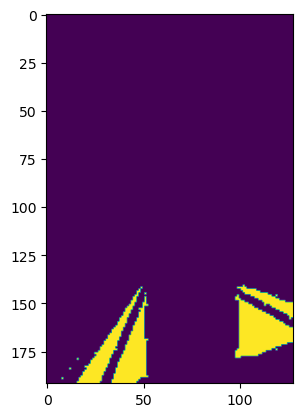

In [22]:
plt.imshow(cat_yi[..., 17])
plt.show()

In [23]:
cat_yi.shape

(192, 128, 32)

In [24]:
y_train = []

for mask in train_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_train.append(y_cat)

y_train = np.array(y_train)

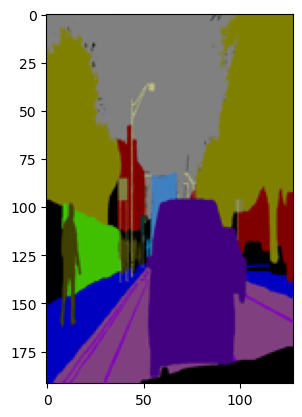

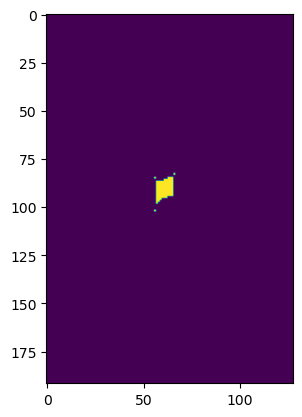

In [25]:
n = 0
plt.imshow(train_masks[n].convert('RGBA'))
plt.show()
img = y_train[n][..., 22]

plt.imshow(img)
plt.show()

In [26]:
y_test = []

for mask in test_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_test.append(y_cat)

y_test = np.array(y_test)

In [27]:
y_val = []

for mask in val_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_val.append(y_cat)

y_val = np.array(y_val)

In [28]:
print(X_train.shape)
print(y_train.shape)

(369, 192, 128, 3)
(369, 192, 128, 32)


In [29]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization, 
                          Conv2D, Conv2DTranspose, concatenate)
from tensorflow.keras.utils import plot_model


def unet_pre_train(num_classes=32, input_shape=(128, 192, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in pre_trained_model.layers[:-5]:
        layer.trainable = False

    x = pre_trained_model.layers[13].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
   
    # UP 1

    # добавили перенос из VGG16
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из VGG16
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из VGG16
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 24, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 48, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 96, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")


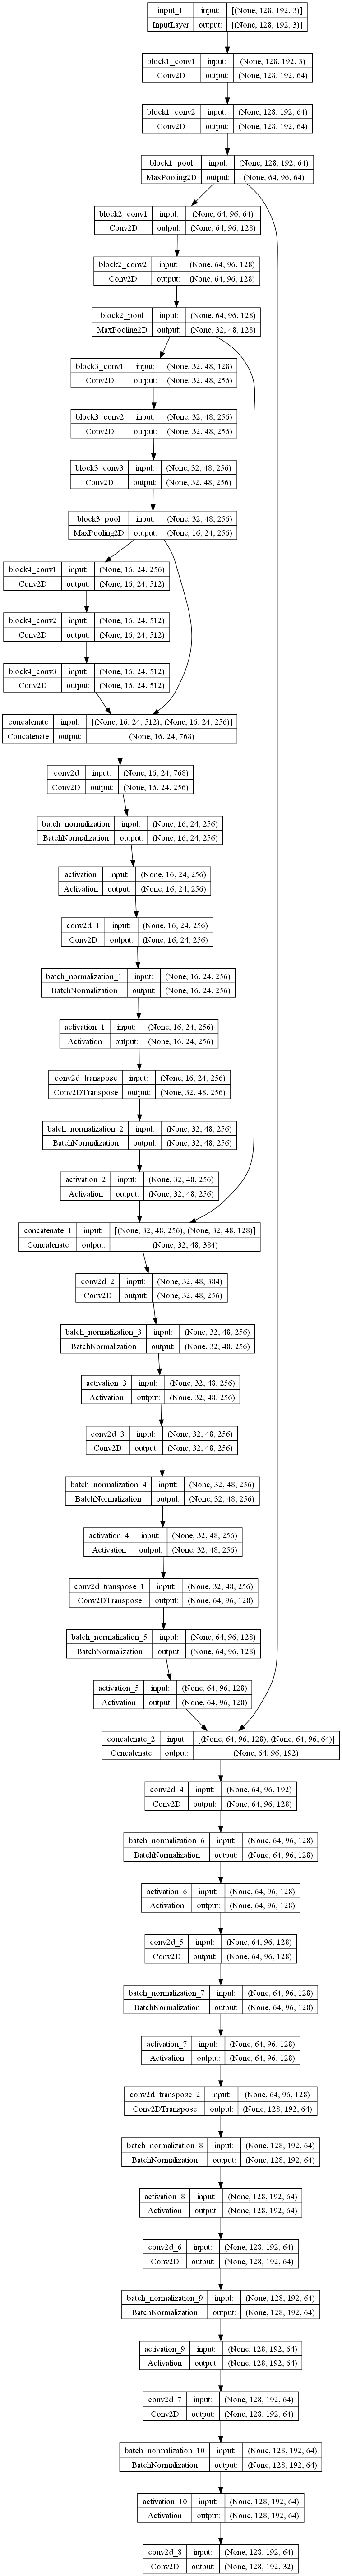

In [30]:
model = unet_pre_train(32, (128, 192, 3))

plot_model(model, to_file='model.png', show_shapes=True)

In [31]:
import keras.backend as K

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

In [32]:
from tensorflow.keras.optimizers import Adam


model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 192, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 128, 192, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 128, 192, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 64, 96, 64)           0         ['block1_conv2[0][0]']        
                                                                                              

In [33]:
sample_image = X_test[1]
sample_mask = y_test[1]

In [34]:
def preprocess_image(image):
    # Perform any necessary preprocessing for the input image
    # For example, you can normalize the image to the range [0, 1]
    return image / 255.0

def show_predictions(model, sample_image, class_dict, sample_mask):
    # Transpose the sample image to match the model's input shape
    sample_image = np.transpose(sample_image, (1, 2, 0))
    
    # Preprocess the sample image
    sample_image = preprocess_image(sample_image)

    # Perform prediction
    pred_mask = model.predict(sample_image[None])[..., 16]
    pred_mask = np.argmax(pred_mask, axis=-1)

    # Decode the class index mask to color mask
    class_colors = class_dict[['r', 'g', 'b']].values
    decoded_mask = class_colors[pred_mask]

    # Display the images
    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image)
    ax[0].set_title('Input Image')

    ax[1].imshow(sample_mask)
    ax[1].set_title('Ground Truth Mask')

    ax[2].imshow(decoded_mask)
    ax[2].set_title('Predicted Mask')

    plt.show()


In [35]:
# Assuming 'sample_image' and 'sample_mask' are your sample image and mask from the test set
# You can change the indices (e.g., sample_image = X_test[1], sample_mask = y_test[1]) as needed.
sample_image = X_test[1]
sample_mask = y_test[1]

# Call the function to show predictions
show_predictions(model, sample_image, class_dict, sample_mask)

ValueError: in user code:

    File "C:\Users\SAMOL\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\SAMOL\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\SAMOL\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\SAMOL\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\SAMOL\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\SAMOL\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 128, 192, 3), found shape=(None, 128, 3, 192)


In [36]:
show_predictions(model)

TypeError: show_predictions() missing 3 required positional arguments: 'sample_image', 'class_dict', and 'sample_mask'

In [ ]:
history = model.fit(preprocess_input(X_train), y_train,
                      epochs=20,
                      batch_size=10,
                      validation_data=(preprocess_input(X_test), y_test),
                      callbacks=[DisplayCallback(patience=5)])

In [ ]:
plt.plot(history.history['val_dice_coef'], label='test')
plt.plot(history.history['dice_coef'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

### Тестируем на валидационных данных

In [ ]:
pred = model.predict(X_val)
print(pred.shape)

In [ ]:
n = 1
class_ = 17
plt.imshow(val_images[n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(val_masks[n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = y_val[n][..., class_]
plt.imshow(img)
plt.title('целевая разметка класс: ' + str(class_))
plt.show()
img = pred[n][..., class_]
plt.imshow(img)
plt.title('предиктивная разметка класс: ' + str(class_))
plt.show()